In [ ]:
%pip install --upgrade transformers
%pip install datasets
%pip install accelerate
%pip install transformers[sentencepiece]
%pip install torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0 --index-url https://download.pytorch.org/whl/cu126
%pip install scikit-learn
%pip install evaluate
%pip install nltk
%pip install pandas
%pip install sklearn
%pip install matplotlib
%pip install optuna

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://download.pytorch.org/whl/cu121
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
import torch
print("Is CUDA available:", torch.cuda.is_available())
print("Number of GPUs available:", torch.cuda.device_count())
print("Current GPU:", torch.cuda.current_device())
print("GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()) if torch.cuda.is_available() else "No GPU detected")
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

Is CUDA available: True
Number of GPUs available: 1
Current GPU: 0
GPU Name: NVIDIA GeForce RTX 3060 Ti
2.6.0+cu126
12.6
True


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoTokenizer
import torch
from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
import matplotlib.pyplot as plt

In [ ]:
# Load your individual dataframes
train_nvuln_df = pd.read_csv('../PHP2IL/train_sem_id_il_nvuln.csv')
train_vuln_df = pd.read_csv('../PHP2IL/train_sem_id_il_vuln.csv')

test_nvuln_df = pd.read_csv('../PHP2IL/test_sem_id_il_nvuln.csv')
test_vuln_df = pd.read_csv('../PHP2IL/test_sem_id_il_vuln.csv')

# 1. Concatenate them (stack rows on top of each other)
# Ensure to apply the initial shuffle correctly to the combined sets
train_df = pd.concat([train_nvuln_df, train_vuln_df], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([test_nvuln_df, test_vuln_df], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)

# Split the training data into training and validation sets
train_df, val_df = train_test_split(train_df, test_size=1/9, random_state=42, shuffle=True)

# Convert the labels to integers
train_df['vulnerable'] = train_df['vulnerable'].astype(int)
val_df['vulnerable'] = val_df['vulnerable'].astype(int)
test_df['vulnerable'] = test_df['vulnerable'].astype(int)

In [14]:
# Choose a pre-trained tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")

# Tokenize the data
def tokenize_function(examples):
    return tokenizer(examples['file_content_in_il'], padding='max_length', truncation=True)

train_encodings = tokenizer(train_df['file_content_in_il'].tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_df['file_content_in_il'].tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_df['file_content_in_il'].tolist(), truncation=True, padding=True)

In [15]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, train_df['vulnerable'].tolist())
val_dataset = CustomDataset(val_encodings, val_df['vulnerable'].tolist())
test_dataset = CustomDataset(test_encodings, test_df['vulnerable'].tolist())

In [ ]:
# Choose a pre-trained model
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at openai-community/gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id

training_args = TrainingArguments(   
    num_train_epochs=4,              
    per_device_train_batch_size=8,   
    per_device_eval_batch_size=8,    
    warmup_steps=100,                
    weight_decay=0.001,
    learning_rate=1e-5,              
    eval_strategy="steps",
    eval_steps=100,
    max_steps=800,
    logging_dir='./logs',
    logging_steps=100,  
)

trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=val_dataset,            
    compute_metrics=compute_metrics,
    tokenizer=tokenizer      
)

device = torch.device("cuda")
trainer.model.to(device)
trainer.train()

C:\Users\jorge\AppData\Local\Temp\ipykernel_3376\645930158.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.720900,0.523261,0.710000,0.823529,0.549020,0.658824
200,0.357300,0.229476,0.890000,0.976190,0.803922,0.881720
300,0.219700,0.346353,0.900000,1.000000,0.803922,0.891304
400,0.201400,0.473962,0.900000,1.000000,0.803922,0.891304
500,0.198400,0.321966,0.900000,1.000000,0.803922,0.891304
600,0.200600,0.512919,0.900000,1.000000,0.803922,0.891304
700,0.181600,0.449982,0.900000,1.000000,0.803922,0.891304
800,0.190500,0.416526,0.900000,1.000000,0.803922,0.891304


TrainOutput(global_step=800, training_loss=0.28380179166793823, metrics={'train_runtime': 209.9837, 'train_samples_per_second': 30.479, 'train_steps_per_second': 3.81, 'total_flos': 865545486336000.0, 'train_loss': 0.28380179166793823, 'epoch': 8.0})

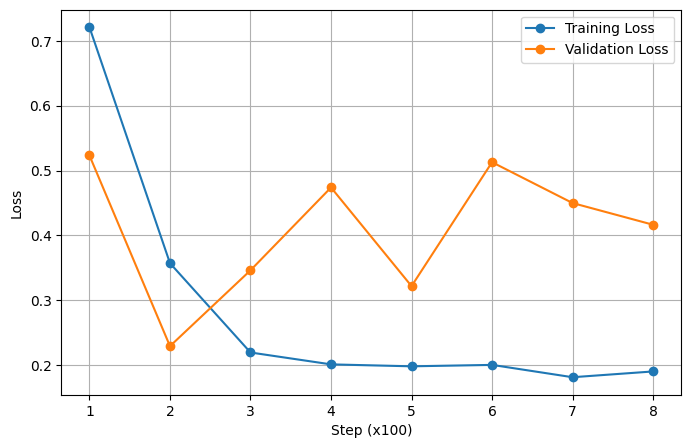

In [18]:
import matplotlib.pyplot as plt

# Obter os logs do treino
logs = trainer.state.log_history

# Separar training loss e validation loss por época
step_checkpoint = []
train_losses = []
val_losses = []

for log in logs:
    if "loss" in log:  # Loss de treino
        train_losses.append(log["loss"])
    if "eval_loss" in log:  # Loss de validação
        val_losses.append(log["eval_loss"])
        step_checkpoint.append(len(val_losses))  # Cada avaliação ocorre no final de uma época

# Criar gráfico de Loss
plt.figure(figsize=(8, 5))
plt.plot(step_checkpoint, train_losses, label="Training Loss", marker="o")
plt.plot(step_checkpoint, val_losses, label="Validation Loss", marker="o")
plt.xlabel("Step (x100)")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

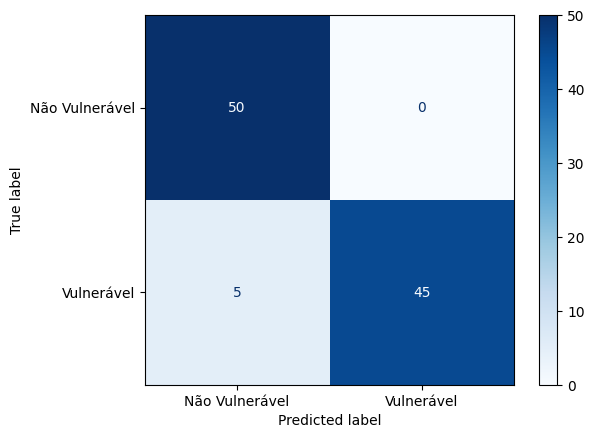

In [19]:
test_outputs = trainer.predict(test_dataset)
predicted_labels = test_outputs.predictions.argmax(axis=1)

# Verdadeiros rótulos do conjunto de teste
true_labels = test_outputs.label_ids

# Gerar a matriz de confusão
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Exibir a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Não Vulnerável", "Vulnerável"])
disp.plot(cmap="Blues")

# # Evaluate the model on the validation set
# val_results = trainer.evaluate()
# print("Validation Results:", val_results)

# # Evaluate the model on the test set
# test_results = trainer.evaluate(test_dataset)
# print("Test Results:", test_results)

In [20]:
accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / conf_matrix.sum()
precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])  # VP / (VP + FP)
recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])     # VP / (VP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy:.5f}")
print(f"Precision {precision:.5f}")
print(f"Recall: {recall:.5f}")
print(f"F1-Score: {f1_score:.5f}")

Accuracy: 0.95000
Precision 1.00000
Recall: 0.90000
F1-Score: 0.94737


In [ ]:
# Check wrong predictions
test_df['predicted'] = predicted_labels
wrong_predictions = test_df[test_df['vulnerable'] != test_df['predicted']]

# Save the wrong predictions
wrong_predictions.to_csv('wrong_predictions_roberta.csv', index=False)
print("Wrong predictions saved to wrong_predictions.csv")


Wrong predictions saved to wrong_predictions.csv


In [ ]:
torch.cuda.empty_cache()
# Delete model logs
# if os.path.exists('./logs'):
#     import shutil
#     shutil.rmtree('./logs')
# Delete trainer_output
import shutil
import os
if os.path.exists('./trainer_output'):
    shutil.rmtree('./trainer_output')

In [23]:
'''
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, precision_recall_fscore_support
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification

# Define the parameter grid
param_grid = {
    'learning_rate': [5e-5, 3e-5, 2e-5],
    'per_device_train_batch_size': [8, 16],
    'num_train_epochs': [3, 4],
    'weight_decay': [0.0, 0.01]
}

# Define a custom scoring function
def custom_scorer(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    return f1

scorer = make_scorer(custom_scorer, greater_is_better=True)

# Implement nested cross-validation
outer_cv = 5
inner_cv = 3

best_params = None
best_score = 0

for train_idx, test_idx in KFold(n_splits=outer_cv).split(train_df):
    train_data = train_df.iloc[train_idx]
    test_data = train_df.iloc[test_idx]
    
    for learning_rate in param_grid['learning_rate']:
        for batch_size in param_grid['per_device_train_batch_size']:
            for num_epochs in param_grid['num_train_epochs']:
                for weight_decay in param_grid['weight_decay']:
                    training_args = TrainingArguments(
                        output_dir='./results',
                        evaluation_strategy="epoch",
                        learning_rate=learning_rate,
                        per_device_train_batch_size=batch_size,
                        per_device_eval_batch_size=batch_size,
                        num_train_epochs=num_epochs,
                        weight_decay=weight_decay,
                        logging_dir='./logs',
                    )
                    
                    model = AutoModelForSequenceClassification.from_pretrained("microsoft/codebert-base", num_labels=2)
                    
                    trainer = Trainer(
                        model=model,
                        args=training_args,
                        train_dataset=train_data,
                        eval_dataset=test_data,
                        compute_metrics=compute_metrics
                    )
                    
                    trainer.train()
                    metrics = trainer.evaluate()
                    score = metrics['eval_f1']
                    
                    if score > best_score:
                        best_score = score
                        best_params = {
                            'learning_rate': learning_rate,
                            'per_device_train_batch_size': batch_size,
                            'num_train_epochs': num_epochs,
                            'weight_decay': weight_decay
                        }

print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)
'''

'\nfrom sklearn.model_selection import KFold\nfrom sklearn.metrics import make_scorer, precision_recall_fscore_support\nfrom transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification\n\n# Define the parameter grid\nparam_grid = {\n    \'learning_rate\': [5e-5, 3e-5, 2e-5],\n    \'per_device_train_batch_size\': [8, 16],\n    \'num_train_epochs\': [3, 4],\n    \'weight_decay\': [0.0, 0.01]\n}\n\n# Define a custom scoring function\ndef custom_scorer(y_true, y_pred):\n    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=\'binary\')\n    return f1\n\nscorer = make_scorer(custom_scorer, greater_is_better=True)\n\n# Implement nested cross-validation\nouter_cv = 5\ninner_cv = 3\n\nbest_params = None\nbest_score = 0\n\nfor train_idx, test_idx in KFold(n_splits=outer_cv).split(train_df):\n    train_data = train_df.iloc[train_idx]\n    test_data = train_df.iloc[test_idx]\n    \n    for learning_rate in param_grid[\'learning_rate\']:\n    

In [24]:
test_outputs

PredictionOutput(predictions=array([[-10.580545  ,   0.91967094],
       [-10.948012  ,   2.7575588 ],
       [-13.652466  ,  -2.1969786 ],
       [ -1.4365734 ,  -4.8746758 ],
       [  1.5316851 ,  -8.0619    ],
       [  2.3617811 ,  -7.0389214 ],
       [ -0.5887616 ,  -5.140012  ],
       [-11.253189  ,   1.6920592 ],
       [  2.1978004 ,  -7.643156  ],
       [  1.8182677 ,  -8.14093   ],
       [  2.4618366 ,  -8.296902  ],
       [  2.1595945 ,  -7.881161  ],
       [-11.031133  ,   0.9137773 ],
       [ -0.03890088,  -6.886917  ],
       [ -7.4150925 ,   1.0178889 ],
       [  1.9540788 ,  -7.915638  ],
       [ -9.741823  ,   1.3888409 ],
       [ -9.741823  ,   1.3888409 ],
       [  1.8619041 ,  -7.218     ],
       [  2.1595945 ,  -7.881161  ],
       [-10.435688  ,   1.8698173 ],
       [ -7.4150925 ,   1.0178889 ],
       [  0.8520583 ,  -5.9507647 ],
       [  1.827383  ,  -7.4870067 ],
       [-11.436197  ,  -0.12725282],
       [  0.4213193 ,  -6.352456  ],
       [ 